# Viscosity-based filtering with boundary-aware and -unware vector Laplacians

In [1]:
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy

In [2]:
import gcm_filters

In [3]:
list(gcm_filters.GridType)

[<GridType.REGULAR: 1>,
 <GridType.REGULAR_WITH_LAND: 2>,
 <GridType.IRREGULAR_WITH_LAND: 3>,
 <GridType.TRIPOLAR_REGULAR_WITH_LAND: 4>,
 <GridType.TRIPOLAR_POP_WITH_LAND: 5>,
 <GridType.VECTOR_C_GRID: 6>]

## MOM6 data

In [4]:
import requests
r = requests.get('https://ndownloader.figshare.com/files/28259862')
with open('MOM6_surface_velocities.nc', 'wb') as fp:
    fp.write(r.content)    
ds = xr.open_dataset('MOM6_surface_velocities.nc', decode_times=False)
ds

<xarray.Dataset>
Dimensions:   (nv: 2, time: 1, xh: 540, xq: 540, yh: 458, yq: 458)
Coordinates:
  * nv        (nv) float64 1.0 2.0
  * time      (time) float64 2.648e+04
  * xh        (xh) float64 -286.7 -286.0 -285.3 -284.7 ... 71.33 72.0 72.67
  * xq        (xq) float64 -286.3 -285.7 -285.0 -284.3 ... 71.0 71.67 72.33 73.0
  * yh        (yh) float64 -79.2 -79.08 -78.95 -78.82 ... 87.64 87.71 87.74
  * yq        (yq) float64 -79.14 -79.01 -78.89 -78.76 ... 87.68 87.73 87.74
Data variables:
    SSU       (time, yh, xq) float64 ...
    SSV       (time, yq, xh) float64 ...
    geolon    (yh, xh) float64 ...
    geolon_c  (yq, xq) float64 ...
    geolon_u  (yh, xq) float64 ...
    geolon_v  (yq, xh) float64 ...
    geolat    (yh, xh) float64 ...
    geolat_c  (yq, xq) float64 ...
    geolat_u  (yh, xq) float64 ...
    geolat_v  (yq, xh) float64 ...
    dyCu      (yh, xq) float64 ...
    dxCu      (yh, xq) float64 ...
    dyCv      (yq, xh) float64 ...
    dxCv      (yq, xh) float64 ...
    area_t    (yh, xh) float64 ...
    wet       (yh, xh) float64 ...
    wet_u     (yh, xq) float64 ...
    wet_v     (yq, xh) float64 ...
    wet_c     (yq, xq) float64 ...

### Preparing the grid info

In [5]:
from xgcm import Grid
coords = {'X': {'center': 'xh', 'right': 'xq'},
            'Y': {'center': 'yh', 'right': 'yq'}
         }
grid = Grid(ds, coords=coords, periodic=['X']) 

In [6]:
ds['dxT'] = grid.interp(ds.dxCu,'X')
ds['dyT'] = grid.interp(ds.dyCv,'Y',boundary='fill')
ds['dxBu'] = grid.interp(ds.dxCv,'X')
ds['dyBu'] = grid.interp(ds.dyCu,'Y',boundary='fill')

In [7]:
# grid info centered at T-points
wet_mask_t = ds.wet
dxT = ds.dxT
dyT = ds.dyT
# grid info centered at U-points
dxCu = ds.dxCu
dyCu = ds.dyCu
area_u = dxCu * dyCu
# grid info centered at V-points
dxCv = ds.dxCv
dyCv = ds.dyCv
area_v = dxCv * dyCv
# grid info centered at vorticity points
wet_mask_q = ds.wet_c
dxBu = ds.dxBu
dyBu = ds.dyBu

In [8]:
dxCu = dxCu.swap_dims({"xq": "xh"})
dyCu = dyCu.swap_dims({"xq": "xh"})
area_u = area_u.swap_dims({"xq": "xh"})

dxCv = dxCv.swap_dims({"yq": "yh"})
dyCv = dyCv.swap_dims({"yq": "yh"})
area_v = area_v.swap_dims({"yq": "yh"})

wet_mask_q = wet_mask_q.swap_dims({"xq": "xh", "yq": "yh"})
dxBu = dxBu.swap_dims({"xq": "xh", "yq": "yh"})
dyBu = dyBu.swap_dims({"xq": "xh", "yq": "yh"})

In [9]:
dx_min = min(dxT.where(wet_mask_t).min(), dyT.where(wet_mask_t).min())
dx_min = dx_min.values
dx_min

array(10717.87766575)

## Define spatial filters

In [10]:
filter_scale = 500000

In [11]:
kappa_iso = xr.ones_like(dxT)
kappa_aniso = xr.zeros_like(dyT)

In [12]:
filter_visc = gcm_filters.Filter(
    filter_scale=filter_scale,
    dx_min=dx_min,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.VECTOR_C_GRID,
    grid_vars={
        'wet_mask_t': wet_mask_t, 'wet_mask_q': wet_mask_q,
        'dxT': dxT, 'dyT': dyT, 
        'dxCu': dxCu, 'dyCu': dyCu, 'area_u': area_u, 
        'dxCv': dxCv, 'dyCv': dyCv, 'area_v': area_v,
        'dxBu': dxBu, 'dyBu': dyBu,
        'kappa_iso': kappa_iso, 'kappa_aniso': kappa_aniso
    }
)
filter_visc

Filter(filter_scale=500000, dx_min=array(10717.87766575), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=52, grid_type=<GridType.VECTOR_C_GRID: 6>)

In [13]:
filter_visc_boundary_unaware = gcm_filters.Filter(
    filter_scale=filter_scale,
    dx_min=dx_min,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.VECTOR_C_GRID,
    grid_vars={
        'wet_mask_t': xr.ones_like(dxT), 'wet_mask_q': xr.ones_like(dxBu),
        'dxT': dxT, 'dyT': dyT, 
        'dxCu': dxCu, 'dyCu': dyCu, 'area_u': area_u, 
        'dxCv': dxCv, 'dyCv': dyCv, 'area_v': area_v,
        'dxBu': dxBu, 'dyBu': dyBu,
        'kappa_iso': kappa_iso, 'kappa_aniso': kappa_aniso
    }
)
filter_visc_boundary_unaware

Filter(filter_scale=500000, dx_min=array(10717.87766575), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=52, grid_type=<GridType.VECTOR_C_GRID: 6>)

## Filter velocities

In [14]:
inside_region = (ds.geolat < 65) & (ds.geolat > -60)  # exclude high-lats

In [15]:
ds_tmp = xr.Dataset()  # temporary dataset with renamed dimensions
ds_tmp['u'] = ds['SSU'].isel(time=0)
ds_tmp['v'] = ds['SSV'].isel(time=0)
ds_tmp['u'] = ds_tmp['u'].swap_dims({'xq':'xh'})
ds_tmp['v'] = ds_tmp['v'].swap_dims({'yq':'yh'})
ds_tmp['u'] = ds_tmp['u'].where(inside_region)  # exclude high-latitude regions that may blow up
ds_tmp['v'] = ds_tmp['v'].where(inside_region)  # exclude high-latitude regions that may blow up

In [16]:
%time (u_filtered, v_filtered) = filter_visc.apply_to_vector(ds_tmp.u, ds_tmp.v, dims=['yh', 'xh'])

CPU times: user 1.17 s, sys: 83.9 ms, total: 1.25 s
Wall time: 1.25 s


In [17]:
%time (u_filtered_boundary_unaware, v_filtered_boundary_unaware) = filter_visc_boundary_unaware.apply_to_vector(ds_tmp.u.fillna(value=0), ds_tmp.v.fillna(value=0), dims=['yh', 'xh'])

CPU times: user 1.01 s, sys: 35.6 ms, total: 1.05 s
Wall time: 1.05 s


In [18]:
ds_tmp['u_filtered'] = u_filtered
ds_tmp['u_filtered'] = ds_tmp['u_filtered'].swap_dims({'xh':'xq'})

ds_tmp['v_filtered'] = v_filtered
ds_tmp['v_filtered'] = ds_tmp['v_filtered'].swap_dims({'yh':'yq'})

ds_tmp['u_filtered_boundary_unaware'] = u_filtered_boundary_unaware
ds_tmp['u_filtered_boundary_unaware'] = ds_tmp['u_filtered_boundary_unaware'].swap_dims({'xh':'xq'})

ds_tmp['v_filtered_boundary_unaware'] = v_filtered_boundary_unaware
ds_tmp['v_filtered_boundary_unaware'] = ds_tmp['v_filtered_boundary_unaware'].swap_dims({'yh':'yq'})

In [19]:
u = ds['SSU'].isel(time=0).where(ds.wet_u).assign_coords({'geolat': ds['geolat_u'], 'geolon': ds['geolon_u']}).compute()
v = ds['SSV'].isel(time=0).where(ds.wet_v).assign_coords({'geolat': ds['geolat_v'], 'geolon': ds['geolon_v']}).compute()
u_filtered = ds_tmp.u_filtered.where(ds.wet_u).assign_coords({'geolat': ds['geolat_u'], 'geolon': ds['geolon_u']}).compute()
v_filtered = ds_tmp.v_filtered.where(ds.wet_v).assign_coords({'geolat': ds['geolat_v'], 'geolon': ds['geolon_v']}).compute()
u_filtered_boundary_unaware = ds_tmp.u_filtered_boundary_unaware.where(ds.wet_u).assign_coords({'geolat': ds['geolat_u'], 'geolon': ds['geolon_u']}).compute()
v_filtered_boundary_unaware = ds_tmp.v_filtered_boundary_unaware.where(ds.wet_v).assign_coords({'geolat': ds['geolat_v'], 'geolon': ds['geolon_v']}).compute()

In [20]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'font.size': 15}
pylab.rcParams.update(params)

from matplotlib import cm
cmap = cm.get_cmap('RdBu_r')
cmap.set_bad(color='0.8', alpha=0) 
cmap2 = cm.get_cmap('BrBG_r')
cmap2.set_bad(color='0.8', alpha=0) 

[Text(0.5, 1.0, 'difference in filtered v')]

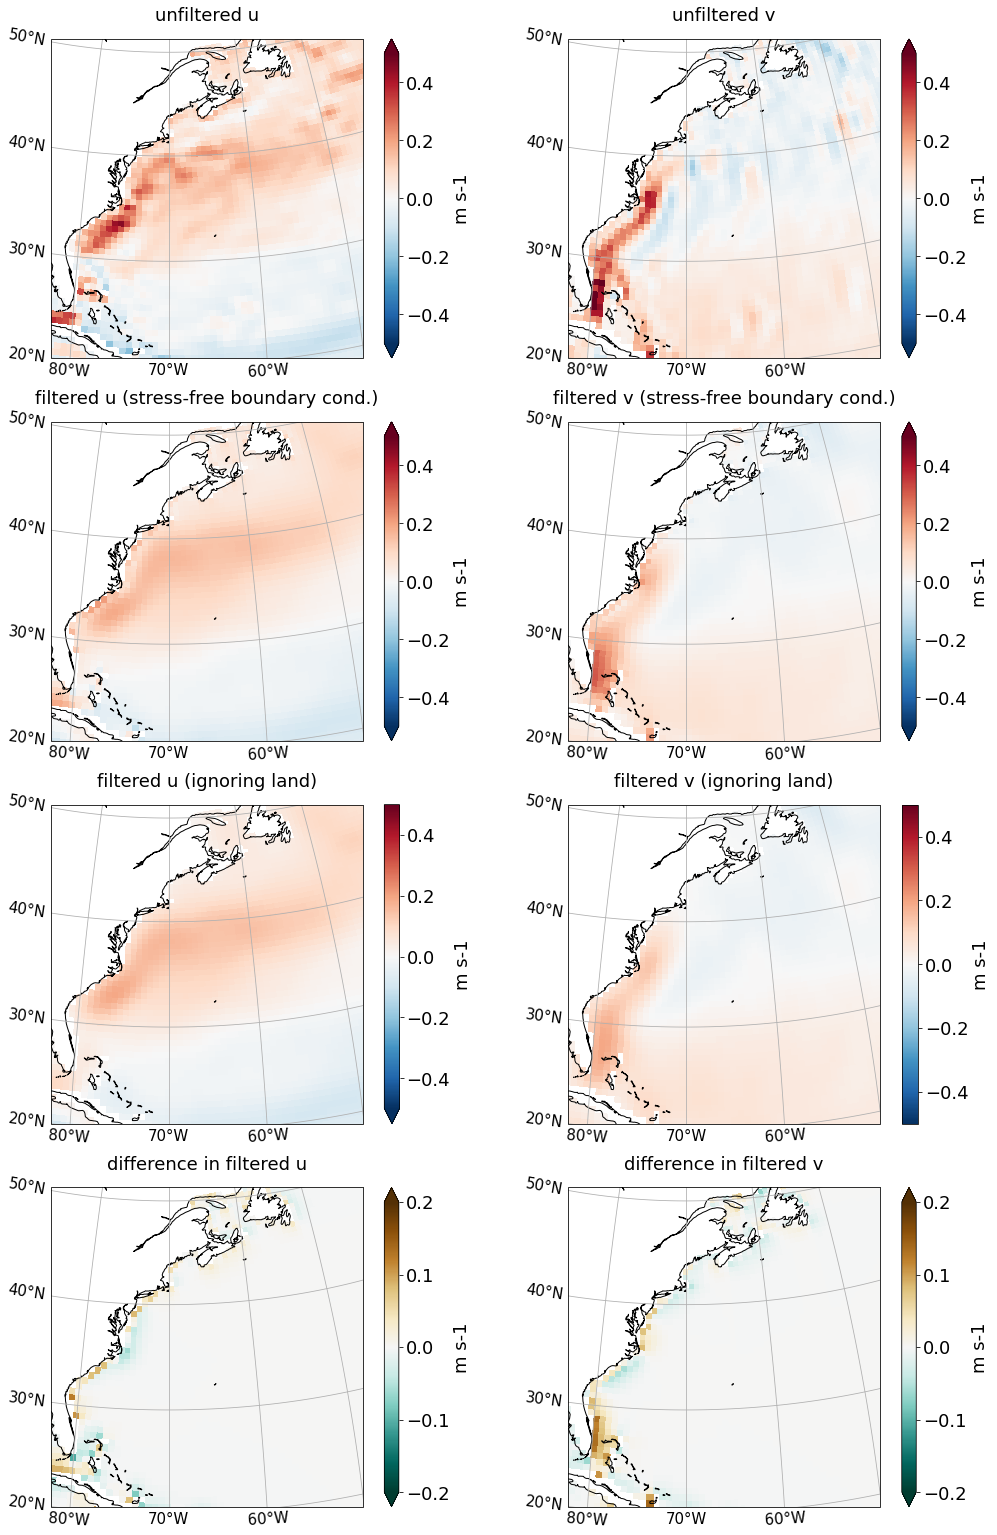

In [21]:
vmax = 0.5
central_lon = -70
central_lat = 35

fig,axs = plt.subplots(4,2,figsize=(17,27),subplot_kw={'projection':ccrs.Orthographic(central_lon, central_lat)})

u.plot(
    ax=axs[0,0], x='geolon', y='geolat', vmin=-vmax, vmax=vmax, 
    cmap=cmap, cbar_kwargs={'label': 'm s-1'},
    transform=ccrs.PlateCarree()
)
v.plot(
    ax=axs[0,1], x='geolon', y='geolat', vmin=-vmax, vmax=vmax, 
    cmap=cmap, cbar_kwargs={'label': 'm s-1'},
    transform=ccrs.PlateCarree()
)
u_filtered.plot(
    ax=axs[1,0], x='geolon', y='geolat', vmin=-vmax, vmax=vmax, 
    cmap=cmap, cbar_kwargs={'label': 'm s-1'},
    transform=ccrs.PlateCarree()
)
v_filtered.plot(
    ax=axs[1,1], x='geolon', y='geolat', vmin=-vmax, vmax=vmax, 
    cmap=cmap, cbar_kwargs={'label': 'm s-1'},
    transform=ccrs.PlateCarree()
)
u_filtered_boundary_unaware.plot(
    ax=axs[2,0], x='geolon', y='geolat', vmin=-vmax, vmax=vmax, 
    cmap=cmap, cbar_kwargs={'label': 'm s-1'},
    transform=ccrs.PlateCarree()
)
v_filtered_boundary_unaware.plot(
    ax=axs[2,1], x='geolon', y='geolat', vmin=-vmax, vmax=vmax, 
    cmap=cmap, cbar_kwargs={'label': 'm s-1'},
    transform=ccrs.PlateCarree()
)
(u_filtered - u_filtered_boundary_unaware).plot(
    ax=axs[3,0], x='geolon', y='geolat', vmin=-0.2, vmax=0.2, 
    cmap=cmap2, cbar_kwargs={'label': 'm s-1', 'ticks': [-0.2,-0.1,0,0.1,0.2]},
    transform=ccrs.PlateCarree()
)
(v_filtered - v_filtered_boundary_unaware).plot(
    ax=axs[3,1], x='geolon', y='geolat', vmin=-0.2, vmax=0.2, 
    cmap=cmap2, cbar_kwargs={'label': 'm s-1', 'ticks': [-0.2,-0.1,0,0.1,0.2]},
    transform=ccrs.PlateCarree()
)

for ax in axs.flatten():
    ax.coastlines()
    ax.set_extent([-82, -50, 20, 50], crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True)
    gl.xlocator = mticker.FixedLocator([-80,-70,-60,-50])
    gl.ylocator = mticker.FixedLocator([20,30,40,50])
    gl.top_labels = False
    gl.right_labels = False

axs[0,0].set(title='unfiltered u')
axs[1,0].set(title='filtered u (stress-free boundary cond.)')
axs[2,0].set(title='filtered u (ignoring land)')
axs[3,0].set(title='difference in filtered u')
axs[0,1].set(title='unfiltered v')
axs[1,1].set(title='filtered v (stress-free boundary cond.)')
axs[2,1].set(title='filtered v (ignoring land)')
axs[3,1].set(title='difference in filtered v')

#fig.savefig('figures/viscosity_filter_%ikm_res%g.png' %(filter_scale/1000,resolution),dpi=400,bbox_inches='tight',pad_inches=0) 
#plt.savefig('figures/viscosity_filter_%ikm_res%g.pdf' %(filter_scale/1000,resolution),dpi=400,bbox_inches='tight',pad_inches=0) 